This notebook replicates Figure 4 in Li et al., (2015). "A motor cortex circuit for motor planning and movement."
<br>
Publication link: https://doi.org/10.1038/nature14178
<br>
Original data link: https://dx.doi.org/10.6080/K0MS3QNT

In [6]:
%matplotlib notebook

In [7]:
import datajoint as dj
from pipeline import lab, experiment, imaging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Some helper functions

In [8]:
def compute_mean_sem(traces):
    return np.mean(traces, axis=0), np.std(traces, axis=0)/np.sqrt(len(traces))

def get_event_time(cell):
    events = experiment.TrialEvent & (imaging.TrialTrace & cell)
    sample = np.mean((events & 'trial_event_type = "sample"').fetch('trial_event_time'))
    delay = np.mean((events & 'trial_event_type = "delay"').fetch('trial_event_time'))
    go = np.mean((events & 'trial_event_type = "go"').fetch('trial_event_time'))
    # aligned time markers
    sample = float(sample - go)
    delay = float(delay - go)
    return [sample, delay, 0]

def get_event_idx(event_times, time):
    if len(event_times) == 1:
        return np.abs(time - event_times).argmin()
    else:
        return [np.abs(time - e).argmin() for e in event_times]

## Figure 4e

In [9]:
# primary keys for example cells
example_cells = [
    {'subject_id': 216219, 'session': 5, 'roi_idx': 22},
    {'subject_id': 216219, 'session': 5, 'roi_idx': 49},
    {'subject_id': 221541, 'session': 13, 'roi_idx': 44},
    {'subject_id': 216219, 'session': 14, 'roi_idx': 9},
    {'subject_id': 216219, 'session': 5, 'roi_idx': 35},
    {'subject_id': 216219, 'session': 6, 'roi_idx': 47},
]

<IPython.core.display.Javascript object>


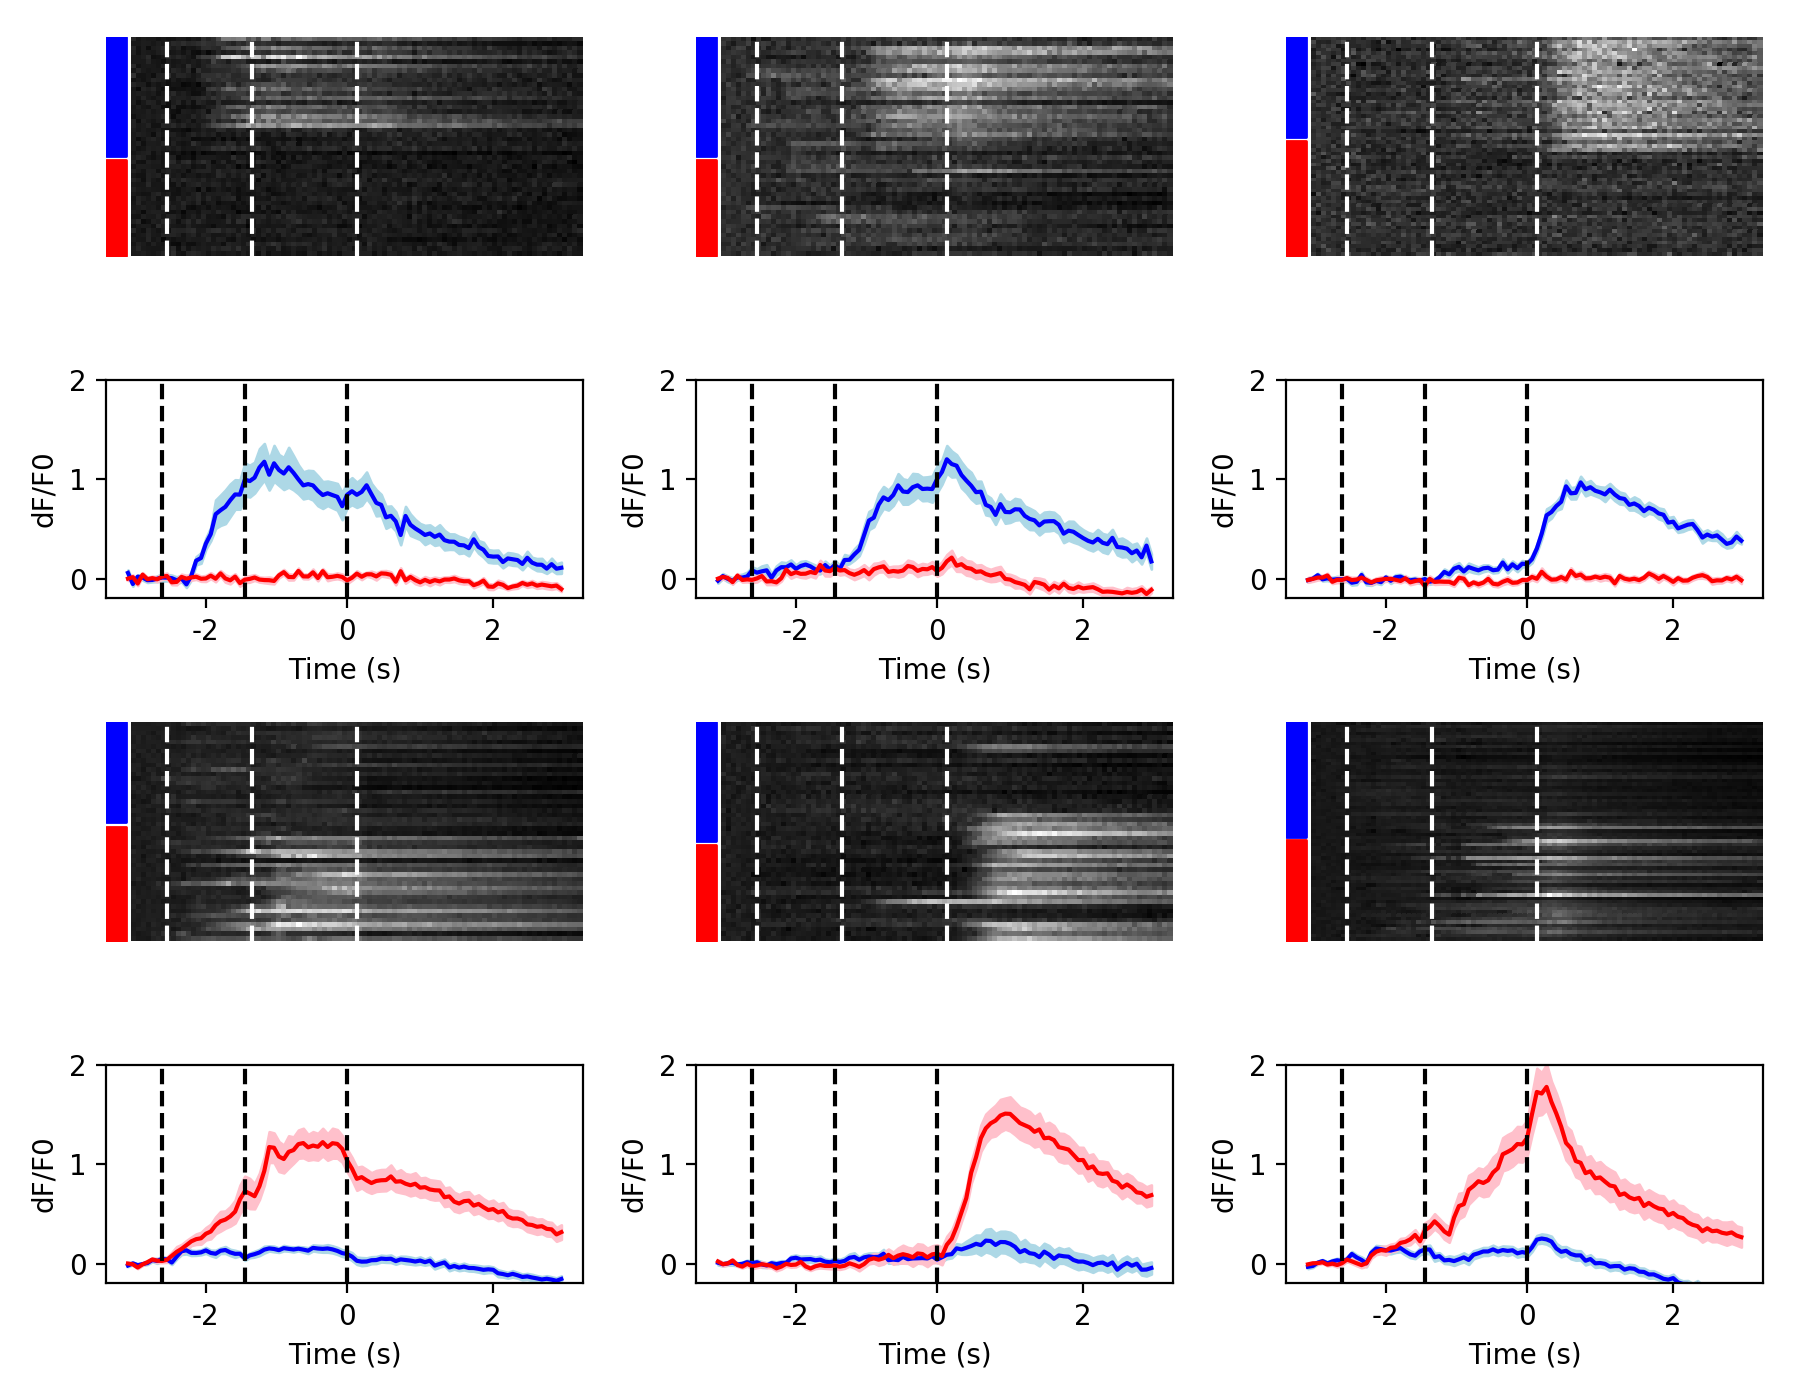

In [114]:
f, axes = plt.subplots(4, 3, figsize=(9, 7))
x2 = -5

axes = axes.flatten()
idx = [[0, 3],
       [1, 4],
       [2, 5],
       [6, 9],
       [7, 10],
       [8, 11]]
axes = [axes[i] for i in idx]

for cell, axs in zip(example_cells, axes):

    # get trace of left trials
    time_left, traces_left = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="left"' & 'outcome="hit"')).fetch(
        'aligned_time', 'dff')
    traces_right = ((imaging.TrialTrace & cell) &
                   (experiment.BehaviorTrial & 'trial_instruction="right"' & 'outcome="hit"')).fetch(
        'dff')
    traces_left = [trace for trace in traces_left]
    traces_right = [trace for trace in traces_right]
    time = time_left[0]
    
    # plot heat map
    sns.heatmap(traces_right+traces_left, cmap='gray', cbar=None, ax=axs[0])
    axs[0].fill_betweenx([0, len(traces_left)-1], -1, x2, color='blue')
    axs[0].fill_betweenx([len(traces_left), len(traces_left) + len(traces_right)], -1, x2, color='red')

    # mark event time points
    event_times = get_event_time(cell)
    for idx in get_event_idx(event_times, time):
        axs[0].axvline(x=idx, linestyle='--', color='white')
        
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xlim((x2, axs[0].get_xlim()[1]))
    
    # mean df/f
    mean_left, sem_left = compute_mean_sem(traces_left)
    mean_right, sem_right = compute_mean_sem(traces_right)
    x = range(0, len(mean_right))
    axs[1].fill_between(x, mean_right-sem_right, mean_right+sem_right, color='lightblue')
    axs[1].plot(x, mean_right, color='blue')
    axs[1].fill_between(x, mean_left-sem_left, mean_left+sem_left, color='pink')
    axs[1].plot(x, mean_left, color='red')
    axs[1].set_ylabel('dF/F0')
    axs[1].set_xlabel('Time (s)')
    xticks = get_event_idx([-2, 0, 2], time)
    axs[1].set_xticks(ticks=xticks)
    labels=['-2', '0', '2']
    axs[1].set_xticklabels(labels)
    
    # mark event time points
    for idx in get_event_idx(event_times, time):
        axs[1].axvline(x=idx, linestyle='--', color='black')
       
    axs[1].set_ylim([-0.2, 2])

f.tight_layout()
f.savefig('/images/example_cells.png', dpi=100)

## Figure 4f

In [123]:
# get pt cells in L5

def plot_summary(cell_type):
    L5_key = (experiment.Session.ImagingDepth & 'imaging_depth>450')
    contra_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Contra"') & \
                      (imaging.Scan.Roi & f'cell_type="{cell_type}"' & 'inc=1') & L5_key

    ipsi_cells = (imaging.RoiAnalyses & 'is_responsive=1' & 'selectivity="Ipsi"') & \
                    (imaging.Scan.Roi & f'cell_type="{cell_type}"' & 'inc=1') & L5_key
    contra_avg_l, contra_avg_r = contra_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
    ipsi_avg_l, ipsi_avg_r = ipsi_cells.fetch('dff_m_l', 'dff_m_r', order_by='frame_rise_half')
    contra_avg_l = [f for f in contra_avg_l]
    contra_avg_r = [f for f in contra_avg_r]
    ipsi_avg_l = [f for f in ipsi_avg_l]
    ipsi_avg_r = [f for f in ipsi_avg_r]
    grid_kws = {"width_ratios": (.45, .45, .02)}
    fig, axes = plt.subplots(1, 3, gridspec_kw=grid_kws, figsize=[4, 3])

    sns.heatmap(contra_avg_r+ipsi_avg_r, cmap='jet', vmax=0.8, vmin=-0.8, ax=axes[0], cbar=None)
    sns.heatmap(contra_avg_l+ipsi_avg_l, cmap='jet', vmax=0.8, vmin=-0.8, ax=axes[1], cbar_ax=axes[2], cbar_kws={'label': 'df/f'})
    axes[0].fill_betweenx([0, len(contra_avg_r)-1], -1, x2, color='blue')
    axes[0].fill_betweenx([len(contra_avg_r), len(contra_avg_r) + len(contra_avg_l)], -1, x2, color='red')
    axes[0].set_xlim((x2, axes[0].get_xlim()[1]))
    axes[1].set_xlim((x2, axes[0].get_xlim()[1]))
    axes[0].set_title('Contra trials', y=0.95, fontsize=10)
    axes[1].set_title('Ipsi trials', y=0.95, fontsize=10)
    fig.suptitle(f'{cell_type} neurons', y=1, x=0.45, fontsize=12)
    
    for ax in axes[:-1]:
        ax.set_xticks([])
        ax.set_yticks([])

    # mark event time points
    for idx in get_event_idx(event_times, time):
        axes[0].axvline(x=idx, linestyle='--', color='black')
        axes[1].axvline(x=idx, linestyle='--', color='black')

    axes[0].set_ylabel('Neuron number')
    
    fig.tight_layout()
    fig.savefig(f'/images/{cell_type} summary.png', dpi=300)

<IPython.core.display.Javascript object>


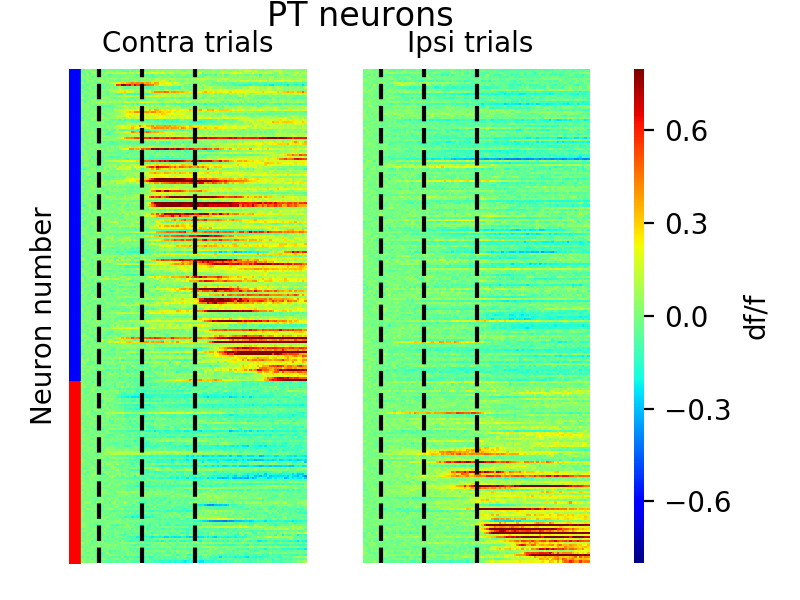

In [124]:
plot_summary('PT')

<IPython.core.display.Javascript object>


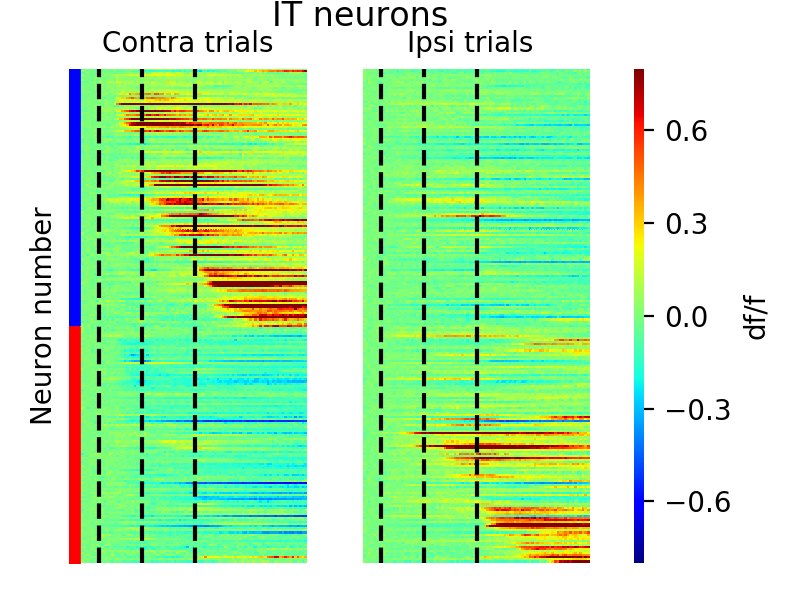

In [125]:
plot_summary('IT')